In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 160)

# ============================================================
# 0. Load panels (SOL + JLP)
# ============================================================

sol_path = "panel_sol.csv"
jlp_path = "panel_jlp.csv"

sol = pd.read_csv(sol_path)
jlp = pd.read_csv(jlp_path)

# Parse hour
for df in [sol, jlp]:
    if df["hour"].dtype == "object":
        df["hour"] = pd.to_datetime(df["hour"])

# Rename liquidation column for clarity
# total_debt_repaid_usd_hour = total liquidation notional per hour
sol = sol.rename(columns={"total_debt_repaid_usd_hour": "total_liq_usd_hour"})
jlp = jlp.rename(columns={"total_debt_repaid_usd_hour": "total_liq_usd_hour"})

# Basic cleaning
req_sol_cols = ["log_return", "vol_abs", "vol_sq", "total_liq_usd_hour", "sol_volume_usd_hour"]
req_jlp_cols = ["log_return", "vol_abs", "vol_sq", "total_liq_usd_hour", "jlp_volume_usd_hour"]

sol_clean = sol.dropna(subset=req_sol_cols).copy()
jlp_clean = jlp.dropna(subset=req_jlp_cols).copy()

print("SOL panel shape:", sol_clean.shape)
print("JLP panel shape:", jlp_clean.shape)




SOL panel shape: (335, 7)
JLP panel shape: (335, 7)


In [2]:
# ============================================================
# 1. Helper utilities
# ============================================================

def add_liq_lag(df, lag=1):
    """
    Create lagged liquidation variable: total_liq_usd_hour shifted by `lag`.
    Used in SOL-4 to test whether liquidation stress spills over into next hour.
    """
    df = df.copy()
    df[f"total_liq_usd_hour_lag{lag}"] = df["total_liq_usd_hour"].shift(lag)
    return df.dropna(subset=[f"total_liq_usd_hour_lag{lag}"])

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    """
    Simple winsorization for robustness: clamp extremes to specified quantiles.
    Used in SOL-5 (outlier dependence).
    """
    lo = s.quantile(lower_q)
    hi = s.quantile(upper_q)
    return s.clip(lower=lo, upper=hi)

def add_realized_vol_4h(df):
    """
    Construct a 4-hour realized volatility proxy:
    rv4_t = sqrt(sum_{k=0..3} (log_return_{t-k}^2))
    Used in SOL-7 to show that the liquidation effect is not just single-hour noise.
    """
    df = df.copy()
    df["rv4"] = (
        df["log_return"]
        .pow(2)
        .rolling(window=4, min_periods=4)
        .sum()
        .pow(0.5)
    )
    return df.dropna(subset=["rv4"])


def run_ols(y, X, name="", hac=False, maxlags=1):
    """
    Generic OLS wrapper so all specs look the same.
    If hac=True, uses Newey-West (HAC) standard errors.
    Returns fitted model.
    """
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit(
        cov_type="HAC",
        cov_kwds={"maxlags": maxlags}
    ) if hac else sm.OLS(y, X).fit()

    print(f"\n=== {name} ===")
    print(model.summary())
    return model

In [3]:
# ============================================================
# 2. SOL models: Does liquidation intensity drive SOL volatility?
# ============================================================

# Convenience references
vol_abs_sol = sol_clean["vol_abs"]
vol_sq_sol = sol_clean["vol_sq"]
liq_sol = sol_clean["total_liq_usd_hour"]
vol_sol = sol_clean["sol_volume_usd_hour"]




In [4]:
# -------------------------
# SOL-1: vol_abs ~ total_liq
# Role: baseline relationship (main text)
# Tests: do hours w/ more liquidation notional have higher absolute returns?
# -------------------------
X_SOL1 = sol_clean[["total_liq_usd_hour"]]
model_SOL1 = run_ols(
    y=vol_abs_sol,
    X=X_SOL1,
    name="SOL-1: vol_abs ~ total_liq"
)


=== SOL-1: vol_abs ~ total_liq ===
                            OLS Regression Results                            
Dep. Variable:                vol_abs   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     257.5
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           2.52e-43
Time:                        12:29:56   Log-Likelihood:                 1284.0
No. Observations:                 335   AIC:                            -2564.
Df Residuals:                     333   BIC:                            -2556.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------


In [5]:
# -------------------------
# SOL-2: vol_abs ~ total_liq + sol_volume
# Role: headline spec (main text)
# Tests: does the liquidation effect remain after controlling for normal trading activity?
# -------------------------
X_SOL2 = sol_clean[["total_liq_usd_hour", "sol_volume_usd_hour"]]
model_SOL2 = run_ols(
    y=vol_abs_sol,
    X=X_SOL2,
    name="SOL-2: vol_abs ~ total_liq + sol_volume"
)


=== SOL-2: vol_abs ~ total_liq + sol_volume ===
                            OLS Regression Results                            
Dep. Variable:                vol_abs   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     164.1
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           2.80e-50
Time:                        12:29:56   Log-Likelihood:                 1303.2
No. Observations:                 335   AIC:                            -2600.
Df Residuals:                     332   BIC:                            -2589.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [6]:
# -------------------------
# SOL-3: vol_sq ~ total_liq + sol_volume
# Role: variance / tail-risk model (main text)
# Tests: do liquidations explain the largest moves (realized variance)?
# -------------------------
X_SOL3 = sol_clean[["total_liq_usd_hour", "sol_volume_usd_hour"]]
model_SOL3 = run_ols(
    y=vol_sq_sol,
    X=X_SOL3,
    name="SOL-3: vol_sq ~ total_liq + sol_volume"
)



=== SOL-3: vol_sq ~ total_liq + sol_volume ===
                            OLS Regression Results                            
Dep. Variable:                 vol_sq   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     1553.
Date:                Wed, 26 Nov 2025   Prob (F-statistic):          2.97e-169
Time:                        12:29:56   Log-Likelihood:                 2510.6
No. Observations:                 335   AIC:                            -5015.
Df Residuals:                     332   BIC:                            -5004.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [7]:
# -------------------------
# SOL-4: vol_abs ~ total_liq_t + total_liq_{t-1} + sol_volume
# Role: spillover / amplification test (appendix or short mention)
# Tests: does liquidation stress persist into the next hour?
# -------------------------
sol_lag = add_liq_lag(sol_clean, lag=1)
y_SOL4 = sol_lag["vol_abs"]
X_SOL4 = sol_lag[["total_liq_usd_hour", "total_liq_usd_hour_lag1", "sol_volume_usd_hour"]]
model_SOL4 = run_ols(
    y=y_SOL4,
    X=X_SOL4,
    name="SOL-4: vol_abs ~ total_liq_t + total_liq_{t-1} + sol_volume"
)



=== SOL-4: vol_abs ~ total_liq_t + total_liq_{t-1} + sol_volume ===
                            OLS Regression Results                            
Dep. Variable:                vol_abs   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     128.5
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           3.76e-55
Time:                        12:29:56   Log-Likelihood:                 1313.2
No. Observations:                 334   AIC:                            -2618.
Df Residuals:                     330   BIC:                            -2603.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

In [8]:
# -------------------------
# SOL-5a: Robustness – drop peak 10.10 hours
# Role: show results are not purely a single shock (appendix)
# You define peak mask based on domain knowledge.
# -------------------------
sol_no_peak = sol_clean.copy()

# Example: drop hours with top 3 liquidation values
peak_idx = sol_no_peak["total_liq_usd_hour"].nlargest(3).index
sol_no_peak = sol_no_peak.drop(index=peak_idx)

y_SOL5a = sol_no_peak["vol_abs"]
X_SOL5a = sol_no_peak[["total_liq_usd_hour", "sol_volume_usd_hour"]]
model_SOL5a = run_ols(
    y=y_SOL5a,
    X=X_SOL5a,
    name="SOL-5a: vol_abs ~ total_liq + sol_volume (drops top-3 liq hours)"
)



=== SOL-5a: vol_abs ~ total_liq + sol_volume (drops top-3 liq hours) ===
                            OLS Regression Results                            
Dep. Variable:                vol_abs   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     63.04
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           6.65e-24
Time:                        12:29:56   Log-Likelihood:                 1317.9
No. Observations:                 332   AIC:                            -2630.
Df Residuals:                     329   BIC:                            -2618.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [9]:
# -------------------------
# SOL-5b: Robustness – winsorize total_liq
# Role: show β is not driven solely by extreme outliers (appendix)
# -------------------------
sol_w = sol_clean.copy()
sol_w["total_liq_usd_hour_w"] = winsorize_series(sol_w["total_liq_usd_hour"], 0.01, 0.99)

y_SOL5b = sol_w["vol_abs"]
X_SOL5b = sol_w[["total_liq_usd_hour_w", "sol_volume_usd_hour"]]
model_SOL5b = run_ols(
    y=y_SOL5b,
    X=X_SOL5b,
    name="SOL-5b: vol_abs ~ winsorized(total_liq) + sol_volume"
)


=== SOL-5b: vol_abs ~ winsorized(total_liq) + sol_volume ===
                            OLS Regression Results                            
Dep. Variable:                vol_abs   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     120.8
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           3.80e-40
Time:                        12:29:56   Log-Likelihood:                 1279.6
No. Observations:                 335   AIC:                            -2553.
Df Residuals:                     332   BIC:                            -2542.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [10]:
# -------------------------
# SOL-6: HAC / Newey-West SEs on the variance model
# Role: correct t-stats for autocorrelation / heteroskedasticity (appendix note)
# -------------------------
X_SOL6 = sol_clean[["total_liq_usd_hour", "sol_volume_usd_hour"]]
model_SOL6 = run_ols(
    y=vol_sq_sol,
    X=X_SOL6,
    name="SOL-6: vol_sq ~ total_liq + sol_volume (HAC SEs)",
    hac=True,
    maxlags=1  # tweak maxlags if you want
)



=== SOL-6: vol_sq ~ total_liq + sol_volume (HAC SEs) ===
                            OLS Regression Results                            
Dep. Variable:                 vol_sq   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     3614.
Date:                Wed, 26 Nov 2025   Prob (F-statistic):          4.66e-226
Time:                        12:29:56   Log-Likelihood:                 2510.6
No. Observations:                 335   AIC:                            -5015.
Df Residuals:                     332   BIC:                            -5004.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

In [11]:
# -------------------------
# SOL-7: Alternative volatility proxy – 4h realized vol
# Role: show liquidation effect survives in a short window RV (appendix figure)
# -------------------------
sol_rv4 = add_realized_vol_4h(sol_clean)
y_SOL7 = sol_rv4["rv4"]
X_SOL7 = sol_rv4[["total_liq_usd_hour", "sol_volume_usd_hour"]]
model_SOL7 = run_ols(
    y=y_SOL7,
    X=X_SOL7,
    name="SOL-7: rv4 ~ total_liq + sol_volume"
)


=== SOL-7: rv4 ~ total_liq + sol_volume ===
                            OLS Regression Results                            
Dep. Variable:                    rv4   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     143.1
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           1.95e-45
Time:                        12:29:56   Log-Likelihood:                 1111.9
No. Observations:                 332   AIC:                            -2218.
Df Residuals:                     329   BIC:                            -2206.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [12]:
# ============================================================
# 3. JLP models: Is JLP less reactive to system-wide liqs?
# ============================================================

# Convenience references
vol_abs_jlp = jlp_clean["vol_abs"]
vol_sq_jlp = jlp_clean["vol_sq"]
liq_jlp = jlp_clean["total_liq_usd_hour"]
vol_jlp = jlp_clean["jlp_volume_usd_hour"]

In [13]:
# -------------------------
# JLP-1: jlp_vol_abs ~ total_liq
# Role: baseline sensitivity (main text next to SOL-1)
# Tests: does JLP volatility move with system-wide liquidation notional at all?
# -------------------------
X_JLP1 = jlp_clean[["total_liq_usd_hour"]]
model_JLP1 = run_ols(
    y=vol_abs_jlp,
    X=X_JLP1,
    name="JLP-1: jlp_vol_abs ~ total_liq"
)


=== JLP-1: jlp_vol_abs ~ total_liq ===
                            OLS Regression Results                            
Dep. Variable:                vol_abs   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     228.2
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           1.24e-39
Time:                        12:29:56   Log-Likelihood:                 1522.8
No. Observations:                 335   AIC:                            -3042.
Df Residuals:                     333   BIC:                            -3034.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [14]:
# -------------------------
# JLP-2: jlp_vol_abs ~ total_liq + jlp_volume
# Role: headline JLP spec (main text comparison vs SOL-2)
# Tests: is JLP still relatively insulated after controlling for its own trading volume?
# -------------------------
X_JLP2 = jlp_clean[["total_liq_usd_hour", "jlp_volume_usd_hour"]]
model_JLP2 = run_ols(
    y=vol_abs_jlp,
    X=X_JLP2,
    name="JLP-2: jlp_vol_abs ~ total_liq + jlp_volume"
)


=== JLP-2: jlp_vol_abs ~ total_liq + jlp_volume ===
                            OLS Regression Results                            
Dep. Variable:                vol_abs   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     196.9
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           4.03e-57
Time:                        12:29:56   Log-Likelihood:                 1566.4
No. Observations:                 335   AIC:                            -3127.
Df Residuals:                     332   BIC:                            -3115.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [15]:
# -------------------------
# JLP-3: jlp_vol_sq ~ total_liq + jlp_volume
# Role: tail-risk model for JLP (main text: compare to SOL-3)
# Tests: do system-wide liquidations generate big variance moves in JLP?
# -------------------------
X_JLP3 = jlp_clean[["total_liq_usd_hour", "jlp_volume_usd_hour"]]
model_JLP3 = run_ols(
    y=vol_sq_jlp,
    X=X_JLP3,
    name="JLP-3: jlp_vol_sq ~ total_liq + jlp_volume"
)


=== JLP-3: jlp_vol_sq ~ total_liq + jlp_volume ===
                            OLS Regression Results                            
Dep. Variable:                 vol_sq   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     1401.
Date:                Wed, 26 Nov 2025   Prob (F-statistic):          1.49e-162
Time:                        12:29:56   Log-Likelihood:                 3014.0
No. Observations:                 335   AIC:                            -6022.
Df Residuals:                     332   BIC:                            -6010.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [16]:
# -------------------------
# JLP-4: Co-movement with SOL vs liquidations
# Role: structure story – JLP tracks SOL generally but is less fragile to liq shocks
# Tests:
#   Step 1: jlp_vol_abs ~ sol_vol_abs
#   Step 2: jlp_vol_abs ~ sol_vol_abs + total_liq
# -------------------------

# Align by hour to pull SOL vol_abs into JLP panel
merged = pd.merge(
    jlp_clean[["hour", "vol_abs"]].rename(columns={"vol_abs": "jlp_vol_abs"}),
    sol_clean[["hour", "vol_abs"]].rename(columns={"vol_abs": "sol_vol_abs"}),
    on="hour",
    how="inner"
)
merged = pd.merge(
    merged,
    jlp_clean[["hour", "total_liq_usd_hour"]],
    on="hour",
    how="inner"
)

# JLP-4a: jlp_vol_abs ~ sol_vol_abs
X_JLP4a = merged[["sol_vol_abs"]]
y_JLP4a = merged["jlp_vol_abs"]
model_JLP4a = run_ols(
    y=y_JLP4a,
    X=X_JLP4a,
    name="JLP-4a: jlp_vol_abs ~ sol_vol_abs"
)

# JLP-4b: jlp_vol_abs ~ sol_vol_abs + total_liq
X_JLP4b = merged[["sol_vol_abs", "total_liq_usd_hour"]]
y_JLP4b = merged["jlp_vol_abs"]
model_JLP4b = run_ols(
    y=y_JLP4b,
    X=X_JLP4b,
    name="JLP-4b: jlp_vol_abs ~ sol_vol_abs + total_liq"
)


=== JLP-4a: jlp_vol_abs ~ sol_vol_abs ===
                            OLS Regression Results                            
Dep. Variable:            jlp_vol_abs   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     8122.
Date:                Wed, 26 Nov 2025   Prob (F-statistic):          5.92e-236
Time:                        12:29:56   Log-Likelihood:                 1977.1
No. Observations:                 335   AIC:                            -3950.
Df Residuals:                     333   BIC:                            -3943.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const  

In [17]:
# ============================================================
# 4. Compact summary tables (for writing)
# ============================================================

# These are just helpers to pull out R2 and key coefficients for the paper.

sol_summary_rows = [
    {"model": "SOL-1 vol_abs ~ liq",              "R2": model_SOL1.rsquared, "coef_liq": model_SOL1.params["total_liq_usd_hour"]},
    {"model": "SOL-2 vol_abs ~ liq + vol",        "R2": model_SOL2.rsquared, "coef_liq": model_SOL2.params["total_liq_usd_hour"]},
    {"model": "SOL-3 vol_sq ~ liq + vol",         "R2": model_SOL3.rsquared, "coef_liq": model_SOL3.params["total_liq_usd_hour"]},
    {"model": "SOL-4 vol_abs ~ liq, liq_lag1",    "R2": model_SOL4.rsquared, "coef_liq": model_SOL4.params["total_liq_usd_hour"], "coef_liq_lag1": model_SOL4.params["total_liq_usd_hour_lag1"]},
    {"model": "SOL-5a drop peaks",               "R2": model_SOL5a.rsquared, "coef_liq": model_SOL5a.params["total_liq_usd_hour"]},
    {"model": "SOL-5b winsorized",               "R2": model_SOL5b.rsquared, "coef_liq": model_SOL5b.params["total_liq_usd_hour_w"]},
    {"model": "SOL-6 HAC var model",             "R2": model_SOL6.rsquared, "coef_liq": model_SOL6.params["total_liq_usd_hour"]},
    {"model": "SOL-7 rv4 ~ liq + vol",           "R2": model_SOL7.rsquared, "coef_liq": model_SOL7.params["total_liq_usd_hour"]},
]

jlp_summary_rows = [
    {"model": "JLP-1 vol_abs ~ liq",             "R2": model_JLP1.rsquared, "coef_liq": model_JLP1.params["total_liq_usd_hour"]},
    {"model": "JLP-2 vol_abs ~ liq + vol",       "R2": model_JLP2.rsquared, "coef_liq": model_JLP2.params["total_liq_usd_hour"]},
    {"model": "JLP-3 vol_sq ~ liq + vol",        "R2": model_JLP3.rsquared, "coef_liq": model_JLP3.params["total_liq_usd_hour"]},
    {"model": "JLP-4a vol_abs ~ sol_vol_abs",    "R2": model_JLP4a.rsquared, "coef_sol_vol": model_JLP4a.params["sol_vol_abs"]},
    {"model": "JLP-4b vol_abs ~ sol_vol + liq",  "R2": model_JLP4b.rsquared, "coef_liq": model_JLP4b.params["total_liq_usd_hour"], "coef_sol_vol": model_JLP4b.params["sol_vol_abs"]},
]

sol_summary_df = pd.DataFrame(sol_summary_rows)
jlp_summary_df = pd.DataFrame(jlp_summary_rows)

print("\n=== SOL summary (for tables in the writeup) ===")
print(sol_summary_df)

print("\n=== JLP summary (for tables in the writeup) ===")
print(jlp_summary_df)


=== SOL summary (for tables in the writeup) ===
                           model        R2      coef_liq  coef_liq_lag1
0            SOL-1 vol_abs ~ liq  0.436048  5.787048e-09            NaN
1      SOL-2 vol_abs ~ liq + vol  0.497089  3.529891e-09            NaN
2       SOL-3 vol_sq ~ liq + vol  0.903445  4.886010e-10            NaN
3  SOL-4 vol_abs ~ liq, liq_lag1  0.538775  2.322508e-09  -2.368163e-09
4              SOL-5a drop peaks  0.277056  1.388294e-08            NaN
5              SOL-5b winsorized  0.421200  3.736976e-09            NaN
6            SOL-6 HAC var model  0.903445  4.886010e-10            NaN
7          SOL-7 rv4 ~ liq + vol  0.465179 -2.654184e-09            NaN

=== JLP summary (for tables in the writeup) ===
                            model        R2      coef_liq  coef_sol_vol
0             JLP-1 vol_abs ~ liq  0.406623  2.670591e-09           NaN
1       JLP-2 vol_abs ~ liq + vol  0.542622  1.682168e-09           NaN
2        JLP-3 vol_sq ~ liq + vol  0.8

In [18]:
# ============================================
# C1. Merge SOL and JLP panels on hour
# ============================================

# Rename volatility columns so we don’t collide
sol_panel = sol_clean[["hour", "vol_abs", "vol_sq", "total_liq_usd_hour"]].rename(
    columns={
        "vol_abs": "sol_vol_abs",
        "vol_sq": "sol_vol_sq",
    }
)

jlp_panel = jlp_clean[["hour", "vol_abs", "vol_sq"]].rename(
    columns={
        "vol_abs": "jlp_vol_abs",
        "vol_sq": "jlp_vol_sq",
    }
)

# Inner join on hour so both assets are present
panel = sol_panel.merge(jlp_panel, on="hour", how="inner")

print("Merged SOL/JLP panel shape:", panel.shape)
panel.head()


Merged SOL/JLP panel shape: (335, 6)


,hour,sol_vol_abs,sol_vol_sq,total_liq_usd_hour,jlp_vol_abs,jlp_vol_sq
0,2025-10-03 01:00:00,0.006645,4.415318e-05,0.0,0.003273,1.071146e-05
1,2025-10-03 02:00:00,0.000469,2.200000e-07,0.0,0.000693,4.810000e-07
2,2025-10-03 03:00:00,0.007677,5.893928e-05,0.0,0.003842,1.475921e-05
3,2025-10-03 04:00:00,0.004456,1.985443e-05,0.0,0.002327,5.416826e-06
4,2025-10-03 05:00:00,0.005103,2.604565e-05,0.0,0.002663,7.092806e-06


In [19]:

# JLP Model 2: vol_abs ~ total_liq_usd_hour + jlp_volume_usd_hour
y_jlp_abs2 = jlp_clean["vol_abs"]
X_jlp_abs2 = jlp_clean[["total_liq_usd_hour", "jlp_volume_usd_hour"]]
X_jlp_abs2 = sm.add_constant(X_jlp_abs2)

model_jlp2 = sm.OLS(y_jlp_abs2, X_jlp_abs2).fit()

# --- SOL models ---
y_sol_abs  = sol_clean["vol_abs"]
X_sol1     = sm.add_constant(sol_clean[["total_liq_usd_hour"]])
model_sol1 = sm.OLS(y_sol_abs, X_sol1).fit()

X_sol2     = sm.add_constant(sol_clean[["total_liq_usd_hour", "sol_volume_usd_hour"]])
model_sol2 = sm.OLS(y_sol_abs, X_sol2).fit()

# --- JLP models ---
y_jlp_abs  = jlp_clean["vol_abs"]
X_jlp1     = sm.add_constant(jlp_clean[["total_liq_usd_hour"]])
model_jlp1 = sm.OLS(y_jlp_abs, X_jlp1).fit()

X_jlp2     = sm.add_constant(jlp_clean[["total_liq_usd_hour", "jlp_volume_usd_hour"]])
model_jlp2 = sm.OLS(y_jlp_abs, X_jlp2).fit()




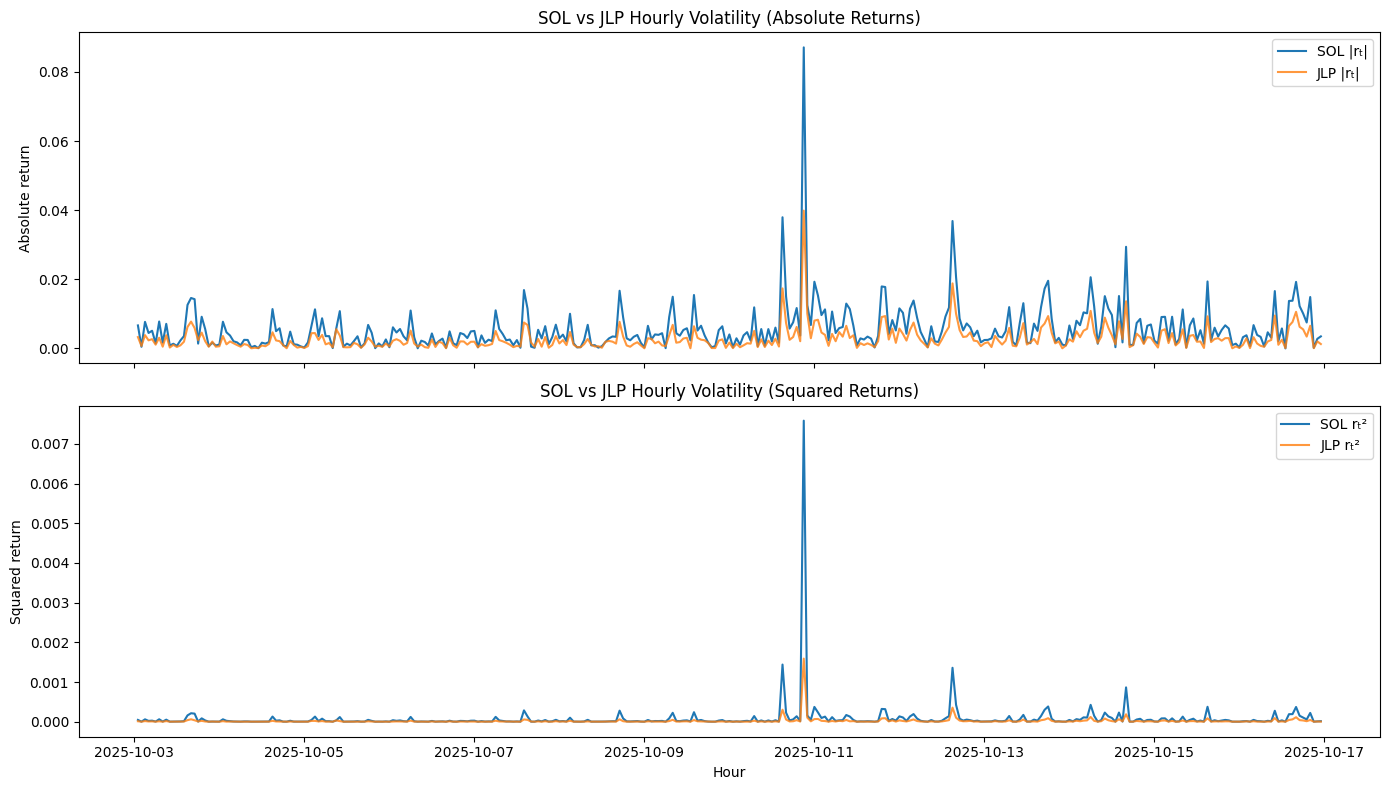

In [20]:
# ============================================
# C2. Time-series comparison of volatility
# ============================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax[0].plot(panel["hour"], panel["sol_vol_abs"], label="SOL |rₜ|")
ax[0].plot(panel["hour"], panel["jlp_vol_abs"], label="JLP |rₜ|", alpha=0.8)
ax[0].set_ylabel("Absolute return")
ax[0].set_title("SOL vs JLP Hourly Volatility (Absolute Returns)")
ax[0].legend()

ax[1].plot(panel["hour"], panel["sol_vol_sq"], label="SOL rₜ²")
ax[1].plot(panel["hour"], panel["jlp_vol_sq"], label="JLP rₜ²", alpha=0.8)
ax[1].set_ylabel("Squared return")
ax[1].set_title("SOL vs JLP Hourly Volatility (Squared Returns)")
ax[1].set_xlabel("Hour")
ax[1].legend()

plt.tight_layout()
plt.show()


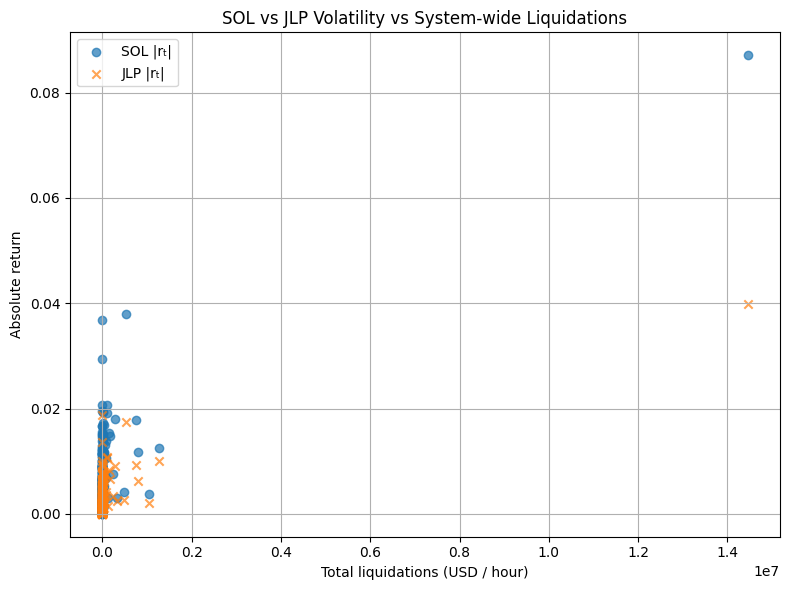

In [21]:
# ============================================
# C3. Scatter: vol_abs vs total_liq (SOL vs JLP)
# ============================================

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    panel["total_liq_usd_hour"],
    panel["sol_vol_abs"],
    alpha=0.7,
    label="SOL |rₜ|",
    marker="o",
)
ax.scatter(
    panel["total_liq_usd_hour"],
    panel["jlp_vol_abs"],
    alpha=0.7,
    label="JLP |rₜ|",
    marker="x",
)

ax.set_xlabel("Total liquidations (USD / hour)")
ax.set_ylabel("Absolute return")
ax.set_title("SOL vs JLP Volatility vs System-wide Liquidations")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


In [22]:
# SOL regression models

y_sol_abs = sol_clean["vol_abs"]
X_sol_abs = sol_clean[["total_liq_usd_hour"]]
X_sol_abs = sm.add_constant(X_sol_abs)
model_sol1 = sm.OLS(y_sol_abs, X_sol_abs).fit()

y_sol_abs2 = sol_clean["vol_abs"]
X_sol_abs2 = sol_clean[["total_liq_usd_hour", "sol_volume_usd_hour"]]
X_sol_abs2 = sm.add_constant(X_sol_abs2)
model_sol2 = sm.OLS(y_sol_abs2, X_sol_abs2).fit()

y_sol_sq = sol_clean["vol_sq"]
X_sol_sq = sol_clean[["total_liq_usd_hour", "sol_volume_usd_hour"]]
X_sol_sq = sm.add_constant(X_sol_sq)
model_sol3 = sm.OLS(y_sol_sq, X_sol_sq).fit()


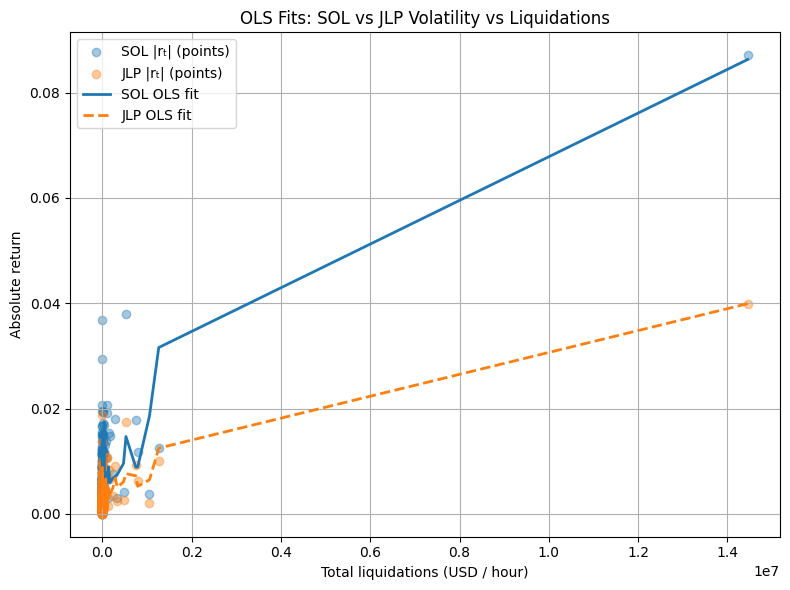

In [23]:
# Optional: add OLS fit lines for SOL and JLP on the same scatter

# Use same X as in your SOL/JLP vol_abs models (total_liq + volume)
X_sol = sm.add_constant(sol_clean[["total_liq_usd_hour", "sol_volume_usd_hour"]])
yhat_sol = model_sol2.predict(X_sol)

X_jlp = sm.add_constant(jlp_clean[["total_liq_usd_hour", "jlp_volume_usd_hour"]])
yhat_jlp = model_jlp2.predict(X_jlp)

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    sol_clean["total_liq_usd_hour"],
    sol_clean["vol_abs"],
    alpha=0.4,
    label="SOL |rₜ| (points)",
)
ax.scatter(
    jlp_clean["total_liq_usd_hour"],
    jlp_clean["vol_abs"],
    alpha=0.4,
    label="JLP |rₜ| (points)",
)

# Sort by liq for smoother lines
sol_order = np.argsort(sol_clean["total_liq_usd_hour"].values)
jlp_order = np.argsort(jlp_clean["total_liq_usd_hour"].values)

ax.plot(
    sol_clean["total_liq_usd_hour"].values[sol_order],
    yhat_sol.values[sol_order],
    linewidth=2,
    label="SOL OLS fit",
)
ax.plot(
    jlp_clean["total_liq_usd_hour"].values[jlp_order],
    yhat_jlp.values[jlp_order],
    linewidth=2,
    linestyle="--",
    label="JLP OLS fit",
)

ax.set_xlabel("Total liquidations (USD / hour)")
ax.set_ylabel("Absolute return")
ax.set_title("OLS Fits: SOL vs JLP Volatility vs Liquidations")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()
